# psychothreshold - Time varying

In [1]:
import numpy as np
import random

# RTDs in real and scaled time units should match
ILD_arr  = [0.5]
ABL_arr = [40]

t_non_decision = 0
rate_lambda = 0.1
T_0 = 0.7 * 1e-3
theta_E = 50
dt = 1e-3
c = 0.1


# def tied_abs_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
#     DV = 0; t = 0
#     chi = 17.37
#     dB = np.sqrt(dt)

#     while True:
#         mu = (2/T_0) * (10**(rate_lambda*ABL/20)) * (rate_lambda * ILD / chi) * (1/c)*np.exp(-t/c)
#         sigma = np.sqrt((2/T_0)* (10**(rate_lambda*ABL/20)) * (1/c)*np.exp(-t/c))

#         DV += mu*dt + sigma * np.random.normal(0, dB)
#         t += dt

#         # bounds are +1 and -1 as simulation is done in normalized units
#         if DV >= theta_E or DV <= -theta_E:
#             return t

max_time = 10.0  # ms
 

def tied_abs_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    max_steps = int(np.ceil(max_time / dt))
    t = np.arange(0, max_steps * dt, dt)
    dB = np.sqrt(dt)
    chi = 17.37

    common = (2 / T_0) * (10 ** (rate_lambda * ABL / 20))
    
    decay = np.exp(-t / c)
    mu = common * (rate_lambda * ILD / chi) * (1 / c) * decay
    sigma = np.sqrt(common * (1 / c) * decay)
    
    noise = np.random.normal(0, dB, size=max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= theta_E) | (DV <= -theta_E))[0]
    if crossing_indices.size > 0:
        t_cross = t[crossing_indices[0]]
        return t_cross + t_non_decision  
    else:
        return np.nan




# def tied_rescaled_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
#     DV = 0; t = 0
#     chi = 17.37
#     dB = np.sqrt(dt)

#     while True:
#         mu = (rate_lambda * theta_E * ILD / chi) 
#         sigma = 1

#         DV += mu*dt + sigma * np.random.normal(0, dB)
#         t += dt
        
#         if DV >= 1 or DV <= -1:
#             return t

def tied_rescaled_units(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, dt):
    chi = 17.37
    dB = np.sqrt(dt)
    
    mu = (rate_lambda * theta_E * ILD / chi)
    sigma = 1
    
    max_steps = int(np.ceil(max_time / dt))
    t_arr = np.arange(0, max_steps * dt, dt)

    
    noise = np.random.normal(0, dB, max_steps)
    
    increments = mu * dt + sigma * noise
    DV = np.cumsum(increments)
    
    crossing_indices = np.where((DV >= 1) | (DV <= -1))[0]
    if crossing_indices.size > 0:
        return t_arr[crossing_indices[0]]
    else:
        return np.nan
    

In [2]:
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [3]:
N_sim = int(10e3)
rt_abs = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
print('abs done')
rt_rescaled = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

abs done


In [4]:
print(f'max of rt abs = {np.nanmax(rt_abs)}')

max of rt abs = 0.882


/tmp/ipykernel_2334007/1077377928.py:14: RuntimeWarning: invalid value encountered in log
  bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A)


Text(0.5, 1.0, 'abs vs rescaled')

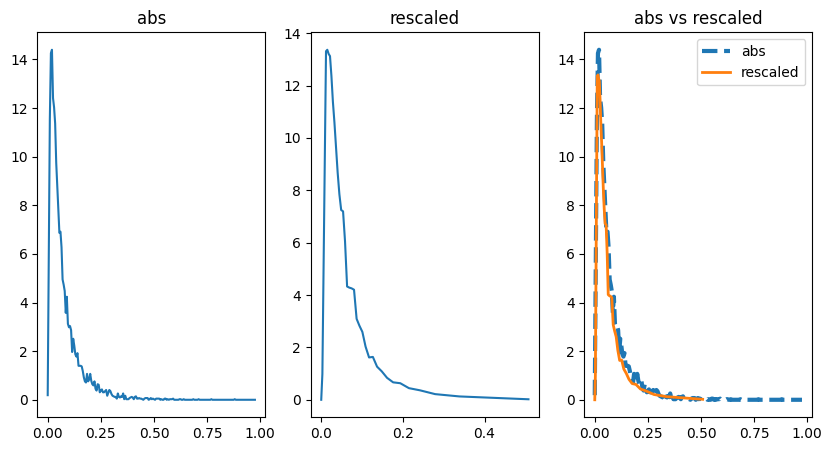

In [5]:
bins = np.arange(0, np.nanmax(rt_abs) + 0.1, 5e-3)

# abs
abs_hist, _ = np.histogram(rt_abs, bins=bins, density=True)
plt.figure(figsize=(10, 5))
plt.subplot(1,3,1)
plt.plot(bins[:-1], abs_hist)
plt.title('abs')
# rescaled
bins_in_tau = np.arange(0, np.nanmax(rt_rescaled) + 0.1, 0.05)
rescaled_hist, _ = np.histogram(rt_rescaled, bins=bins_in_tau, density=True)

A = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL_arr[0] / 20))
bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A)

dtau_by_dt = (2 / (T_0 * (theta_E**2))) * (10**(rate_lambda*ABL_arr[0]/20)) * (1/c)*(np.exp(-bins_in_t_from_tau[:-1]/c))
rescaled_hist_times_dtau_dt = rescaled_hist * dtau_by_dt

plt.subplot(1,3,2)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt)
plt.title('rescaled')
plt.subplot(1,3,3)
# plot both
plt.plot(bins[:-1], abs_hist, label='abs', ls='--', lw=3)
plt.plot(bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt, label='rescaled', lw=2)
plt.legend()
plt.title('abs vs rescaled')

In [17]:
print(f'A is {A}')
print(f'max of tau = {np.nanmax(bins_in_tau)} ')

A is 1.811306505669844
max of tau = 7.1000000000000005 


# for diff ABL ?

In [6]:
ABL_arr = [60]
abl_60_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

print('60 done')
ABL_arr = [20]
abl_20_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

ABL_arr = [40]
abl_40_rel_rt = Parallel(n_jobs=30)(delayed(tied_rescaled_units)(ILD_arr[0], ABL_arr[0], rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))


60 done


Text(0.5, 1.0, 'ABL 60 vs 20')

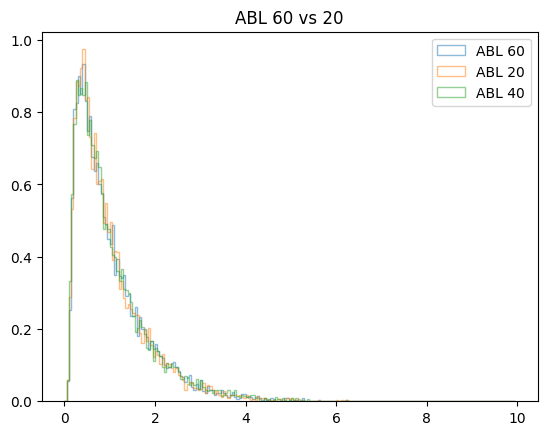

In [7]:
np.max(abl_60_rel_rt), np.max(abl_20_rel_rt)
bins = np.arange(0, 10, 0.05)
plt.hist(abl_60_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 60', histtype='step')
plt.hist(abl_20_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 20', histtype='step')
plt.hist(abl_40_rel_rt, bins=bins, density=True, alpha=0.5, label='ABL 40', histtype='step')
plt.legend()
plt.title('ABL 60 vs 20')

In [8]:
def rho_tau_vs_t(rt_rescaled,ABL):
    bins_in_tau = np.arange(0, max(rt_rescaled) + 0.1, 0.1)
    rescaled_hist, _ = np.histogram(rt_rescaled, bins=bins_in_tau, density=True) # rho(tau)

    A = (2 / (T_0 * (theta_E ** 2))) * (10 ** (rate_lambda * ABL / 20))
    bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A) # t

    dtau_by_dt = (2 / (T_0 * (theta_E**2))) * (10**(rate_lambda*ABL/20)) * (1/c)*(np.exp(-bins_in_t_from_tau[:-1]/c))
    rescaled_hist_times_dtau_dt = rescaled_hist * dtau_by_dt
    return bins_in_t_from_tau[:-1], rescaled_hist_times_dtau_dt

In [9]:
t_60, rt_60_t_units = rho_tau_vs_t(abl_60_rel_rt, 60)
t_20, rt_20_t_units = rho_tau_vs_t(abl_20_rel_rt, 20)
t_40, rt_40_t_units = rho_tau_vs_t(abl_40_rel_rt, 40)

/tmp/ipykernel_2334007/3302097018.py:6: RuntimeWarning: invalid value encountered in log
  bins_in_t_from_tau = -c * np.log(1 - bins_in_tau / A) # t


In [10]:
rt_abs_60 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 60, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
rt_abs_40 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 40, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))
rt_abs_20 = Parallel(n_jobs=30)(delayed(tied_abs_units)(ILD_arr[0], 20, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

Text(0.5, 1.0, 'RTDs for ABL, abs t')

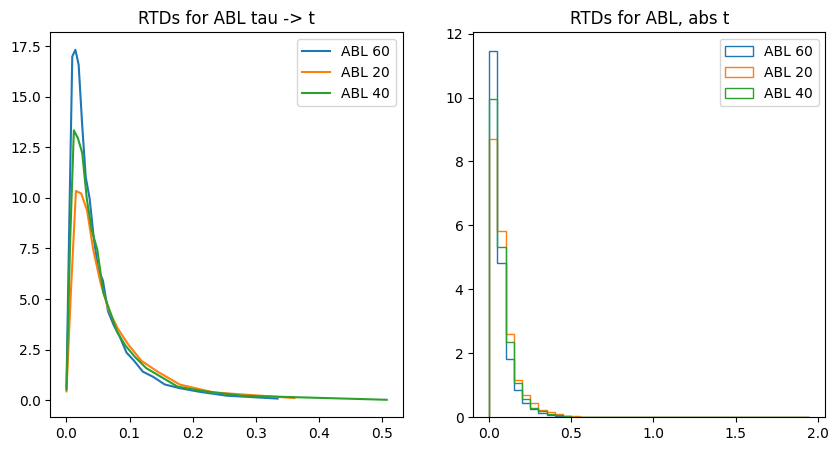

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(t_60, rt_60_t_units, label='ABL 60')
plt.plot(t_20, rt_20_t_units, label='ABL 20')
plt.plot(t_40, rt_40_t_units, label='ABL 40')
plt.legend()
plt.title('RTDs for ABL tau -> t')

plt.subplot(1,2,2)
t_bins = np.arange(0, 2, 0.05)
plt.hist(rt_abs_60, bins=t_bins, density=True,  label='ABL 60', histtype='step')
plt.hist(rt_abs_20, bins=t_bins, density=True,  label='ABL 20', histtype='step')
plt.hist(rt_abs_40, bins=t_bins, density=True,  label='ABL 40', histtype='step')
plt.legend()
plt.title('RTDs for ABL, abs t')

# Q-Q plot

In [12]:
quantiles = np.arange(0.05, 0.95, 0.05)
# remove nans before taking quantiles
rt_abs_60 = np.array([rt for rt in rt_abs_60 if not np.isnan(rt)])
rt_abs_40 = np.array([rt for rt in rt_abs_40 if not np.isnan(rt)])
rt_abs_20 = np.array([rt for rt in rt_abs_20 if not np.isnan(rt)])

quantiles_abs_60 = np.quantile(rt_abs_60, quantiles)
quantiles_abs_40 = np.quantile(rt_abs_40, quantiles)
quantiles_abs_20 = np.quantile(rt_abs_20, quantiles)

Text(0.5, 1.0, 'Q-Q abs units')

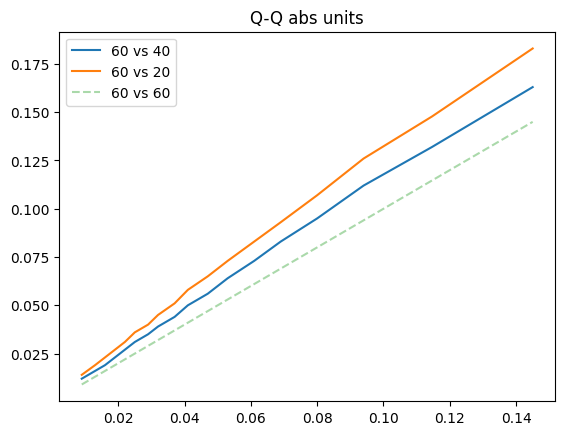

In [13]:
plt.plot(quantiles_abs_60, quantiles_abs_40, label='60 vs 40')
plt.plot(quantiles_abs_60, quantiles_abs_20, label='60 vs 20')
plt.plot(quantiles_abs_60, quantiles_abs_60, label='60 vs 60', ls='--', alpha=0.4)

plt.legend()
plt.title('Q-Q abs units')